# Neural Network Training for Beginners

Now that you understand how data flows through a neural network, let's learn the most important part:
**How does the network actually learn?**

This notebook will teach you:
- What "training" means
- How to measure if the network is doing well (loss function)
- How to improve the network (backpropagation)
- How to train step by step

In [2]:
# Import what we need
import numpy as np
import matplotlib.pyplot as plt

print("Ready to learn neural network training!")

Ready to learn neural network training!


## Step 1: What is Training?

**Training** means adjusting the weights so the network gives better answers.

Think of it like learning to throw a basketball:
- First throw: You miss badly
- You adjust your aim and strength
- Second throw: You get closer
- Keep adjusting until you hit the target

The neural network does the same thing with its weights!

In [5]:
# Let's recreate our simple network from the previous notebook
def sigmoid(x):
    """The sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to prevent overflow

def sigmoid_derivative(x):
    """Derivative of sigmoid - needed for backpropagation"""
    s = sigmoid(x)
    return s * (1 - s)

class TrainableNeuralNetwork:
    def __init__(self):
        """Initialize our trainable 2→2→1 neural network"""
        print("🧠 Creating a trainable neural network...")
        
        # Start with random small weights (this is important!)
        np.random.seed(42)  # For reproducible results
        self.weights_input_to_hidden = np.random.uniform(-1, 1, (2, 2))
        print("Input→Hidden weights:\n", self.weights_input_to_hidden)
        self.weights_hidden_to_output = np.random.uniform(-1, 1, (2, 1))
        print("Hidden→Output weights:\n", self.weights_hidden_to_output)
        
        # Biases (we'll keep these simple for now)
        self.bias_hidden = np.zeros((1, 2))
        self.bias_output = np.zeros((1, 1))
        print(f"Biases: Hidden {self.bias_hidden}  Output {self.bias_output}")
   
        print("✅ Network created with random weights!")
        print(f"Input→Hidden weights:\n{self.weights_input_to_hidden}")
        print(f"Hidden→Output weights:\n{self.weights_hidden_to_output}")

# Create our trainable network
network = TrainableNeuralNetwork()

🧠 Creating a trainable neural network...
Input→Hidden weights:
 [[-0.25091976  0.90142861]
 [ 0.46398788  0.19731697]]
Hidden→Output weights:
 [[-0.68796272]
 [-0.68801096]]
Biases: Hidden [[0. 0.]]  Output [[0.]]
✅ Network created with random weights!
Input→Hidden weights:
[[-0.25091976  0.90142861]
 [ 0.46398788  0.19731697]]
Hidden→Output weights:
[[-0.68796272]
 [-0.68801096]]


## Step 2: Forward Pass (Review)

Let's implement the forward pass again, but this time we'll save the intermediate values.
We need these saved values for training!

In [19]:
def forward_pass(network, inputs):
    """Forward pass that saves intermediate values for training"""
    
    # Convert input to proper shape
    if inputs.ndim == 1:
        inputs = inputs.reshape(1, -1)
    
    # Input to Hidden Layer
    hidden_input = np.dot(inputs, network.weights_input_to_hidden) + network.bias_hidden
    hidden_output = sigmoid(hidden_input)
    
    # Hidden to Output Layer
    output_input = np.dot(hidden_output, network.weights_hidden_to_output) + network.bias_output
    final_output = sigmoid(output_input)
    
    # Return everything (we need these for training!)
    return {
        'inputs': inputs,
        'hidden_input': hidden_input,
        'hidden_output': hidden_output,
        'output_input': output_input,
        'final_output': final_output
    }

# Test the forward pass
test_input = np.array([0.5, 0.8])
result = forward_pass(network, test_input)

print(f"Input: {test_input}")
print(f"Network output: {result['final_output'][0][0]:.4f}")
print(type(result['final_output']))




Input: [0.5 0.8]
Network output: 0.3033
<class 'numpy.ndarray'>


## Step 3: The Loss Function - How Wrong Are We?

Before we can improve, we need to measure how wrong our network is.
This is called the **loss function** or **cost function**.

Think of it like a score in a game - but lower is better!

In [21]:
def calculate_loss(predicted, actual):
    """
    Calculate how wrong our prediction is
    We use Mean Squared Error (MSE) - a simple and effective loss function
    """
    # MSE = (predicted - actual)²
    error = predicted - actual
    loss = np.mean(error ** 2)
    return loss, error

# Example: Let's say we want the network to output 1.0 when we give it [0.5, 0.8]
target_output = 1.0
# Extract the final output value from the network's result
# result['final_output'] is a 2D array, so we need [0][0] to get the scalar value
current_output = result['final_output'][0][0]

loss, error = calculate_loss(current_output, target_output)

print(f"🎯 Target output: {target_output}")
print(f"🤖 Network output: {current_output:.4f}")
print(f"❌ Error: {error:.4f}")
print(f"📊 Loss (MSE): {loss:.4f}")
print("\n💡 Lower loss = better performance!")

🎯 Target output: 1.0
🤖 Network output: 0.3033
❌ Error: -0.6967
📊 Loss (MSE): 0.4854

💡 Lower loss = better performance!


## Step 4: Backpropagation - The Magic of Learning

**Backpropagation** is how the network learns from its mistakes.

It works backwards through the network:
1. Start with the error at the output
2. Figure out how much each weight contributed to that error
3. Adjust the weights to reduce the error

It's like tracing back through your basketball throw to see what went wrong!

In [28]:
def backpropagation(network, forward_result, target, learning_rate=0.1):
    """
    The heart of neural network learning!
    This function calculates how to adjust each weight to reduce the error.
    """
    
    # Get values from forward pass
    inputs = forward_result['inputs']
    hidden_output = forward_result['hidden_output']
    final_output = forward_result['final_output']
    output_input = forward_result['output_input']
    hidden_input = forward_result['hidden_input']
    
    # Step 1: Calculate error at output layer
    output_error = final_output - target
    
    # Step 2: Calculate how much to change output layer weights
    # This uses the chain rule from calculus (don't worry about the math details!)
    output_delta = output_error * sigmoid_derivative(output_input)
    
    # Step 3: Calculate error for hidden layer
    hidden_error = np.dot(output_delta, network.weights_hidden_to_output.T)
    hidden_delta = hidden_error * sigmoid_derivative(hidden_input)
    
    # Step 4: Calculate weight updates
    # How much should we change each weight?
    weights_hidden_to_output_update = np.dot(hidden_output.T, output_delta)
    weights_input_to_hidden_update = np.dot(inputs.T, hidden_delta)
    
    # Step 5: Update the weights (this is the actual learning!)
    network.weights_hidden_to_output -= learning_rate * weights_hidden_to_output_update
    network.weights_input_to_hidden -= learning_rate * weights_input_to_hidden_update
    
    # Also update biases
    network.bias_output -= learning_rate * np.mean(output_delta, axis=0, keepdims=True)
    network.bias_hidden -= learning_rate * np.mean(hidden_delta, axis=0, keepdims=True)
    
    return np.mean(output_error ** 2)  # Return the loss

print("🔄 Backpropagation function ready!")
print("This is where the magic happens - the network learns from its mistakes!")

🔄 Backpropagation function ready!
This is where the magic happens - the network learns from its mistakes!


## Step 4.5: Understanding Backpropagation with Diagrams

Now let's visualize exactly how backpropagation works! Run the cell below to see the diagram and step-by-step explanation.

In [1]:
# Let's create a simple backpropagation explanation right here
def explain_backpropagation_simple():
    """Simple explanation of backpropagation with a visual diagram"""
    print("🎯 BACKPROPAGATION EXPLAINED SIMPLY")
    print("="*50)
    
    print("\n📊 EXAMPLE: Network predicts 0.65, but target is 1.0")
    print("\n🔵 FORWARD PASS (Left → Right):")
    print("   Input [0.5, 0.8] → Hidden [0.73, 0.68] → Output [0.65]")
    print("   Error = 0.65 - 1.0 = -0.35 (too low!)")
    
    print("\n🔴 BACKWARD PASS (Right ← Left):")
    print("   1. Output error: -0.35")
    print("   2. Output delta: -0.35 × sigmoid'(x) = -0.08")
    print("   3. Hidden errors: spread the blame backward")
    print("   4. Weight updates: adjust each weight to reduce error")
    
    print("\n🎯 THE PROCESS:")
    print("   ┌─────────┐    ┌─────────┐    ┌─────────┐")
    print("   │ Input 1 │───▶│Hidden 1 │───▶│         │")
    print("   │  [0.5]  │    │ [0.73]  │    │ Output  │")
    print("   └─────────┘    └─────────┘    │ [0.65]  │")
    print("   ┌─────────┐    ┌─────────┐    │Target:1.0│")
    print("   │ Input 2 │───▶│Hidden 2 │───▶│Error:-0.35│")
    print("   │  [0.8]  │    │ [0.68]  │    └─────────┘")
    print("   └─────────┘    └─────────┘")
    print("")
    print("   Forward: Data flows →")
    print("   Backward: Error flows ← and updates weights")
    
    print("\n🔄 WEIGHT UPDATES:")
    print("   • Each weight gets adjusted based on its contribution to error")
    print("   • If weight caused output to be too low → increase it")
    print("   • If weight caused output to be too high → decrease it")
    print("   • Learning rate controls how big the adjustments are")
    
    print("\n✨ THE MAGIC:")
    print("   • This happens automatically for ANY error")
    print("   • Network learns from EVERY mistake")
    print("   • After thousands of examples → very accurate predictions!")
    print("\n" + "="*50)

# Show the explanation
explain_backpropagation_simple()

# Also show the saved diagram
print("\n💡 TIP: Check the file 'Neural Networks/images/backpropagation_diagram.png'")
print("    for a detailed visual diagram of this process!")

🎯 BACKPROPAGATION EXPLAINED SIMPLY

📊 EXAMPLE: Network predicts 0.65, but target is 1.0

🔵 FORWARD PASS (Left → Right):
   Input [0.5, 0.8] → Hidden [0.73, 0.68] → Output [0.65]
   Error = 0.65 - 1.0 = -0.35 (too low!)

🔴 BACKWARD PASS (Right ← Left):
   1. Output error: -0.35
   2. Output delta: -0.35 × sigmoid'(x) = -0.08
   3. Hidden errors: spread the blame backward
   4. Weight updates: adjust each weight to reduce error

🎯 THE PROCESS:
   ┌─────────┐    ┌─────────┐    ┌─────────┐
   │ Input 1 │───▶│Hidden 1 │───▶│         │
   │  [0.5]  │    │ [0.73]  │    │ Output  │
   └─────────┘    └─────────┘    │ [0.65]  │
   ┌─────────┐    ┌─────────┐    │Target:1.0│
   │ Input 2 │───▶│Hidden 2 │───▶│Error:-0.35│
   │  [0.8]  │    │ [0.68]  │    └─────────┘
   └─────────┘    └─────────┘

   Forward: Data flows →
   Backward: Error flows ← and updates weights

🔄 WEIGHT UPDATES:
   • Each weight gets adjusted based on its contribution to error
   • If weight caused output to be too low → inc

## Step 5: Training Loop - Putting It All Together

Now let's train our network! We'll:
1. Give it an input and desired output
2. See what it predicts (forward pass)
3. Calculate the error
4. Adjust the weights (backpropagation)
5. Repeat many times!

In [27]:
def train_network_simple_example():
    """Train the network on a simple example"""
    
    # Simple training data: we want the network to learn that [1, 1] should output 1
    # and [0, 0] should output 0
    training_inputs = np.array([[1, 1], [0, 0], [1, 0], [0, 1]])
    training_outputs = np.array([[1], [0], [0.5], [0.5]])
    
    losses = []
    epochs = 1000  # Number of training iterations
    
    print("🚀 Starting training...")
    print(f"Training for {epochs} epochs")
    
    for epoch in range(epochs):
        total_loss = 0
        
        # Train on each example
        for i in range(len(training_inputs)):
            # Forward pass
            forward_result = forward_pass(network, training_inputs[i])
            
            # Backpropagation (learning!)
            loss = backpropagation(network, forward_result, training_outputs[i])
            total_loss += loss
        
        # Average loss for this epoch
        avg_loss = total_loss / len(training_inputs)
        losses.append(avg_loss)
        
        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")
    
    print(f"\n✅ Training complete! Final loss: {losses[-1]:.6f}")
    return losses

# Train the network!
training_losses = train_network_simple_example()

🚀 Starting training...
Training for 1000 epochs
Epoch 0: Loss = 0.022083
Epoch 100: Loss = 0.017400
Epoch 200: Loss = 0.014063
Epoch 300: Loss = 0.011635
Epoch 400: Loss = 0.009821
Epoch 500: Loss = 0.008429
Epoch 600: Loss = 0.007335
Epoch 700: Loss = 0.006459
Epoch 800: Loss = 0.005745
Epoch 900: Loss = 0.005155

✅ Training complete! Final loss: 0.004665


## Step 6: Test the Trained Network

Let's see how well our network learned!

In [24]:
def test_trained_network():
    """Test our trained network"""
    print("🧪 Testing the trained network:")
    print("=" * 40)
    
    test_cases = [
        ([1, 1], "Should be close to 1.0"),
        ([0, 0], "Should be close to 0.0"),
        ([1, 0], "Should be close to 0.5"),
        ([0, 1], "Should be close to 0.5")
    ]
    
    for inputs, expected in test_cases:
        result = forward_pass(network, np.array(inputs))
        output = result['final_output'][0][0]
        
        print(f"Input: {inputs} → Output: {output:.4f} ({expected})")
    
    print("\n🎉 Look how much the network has learned!")

test_trained_network()

🧪 Testing the trained network:
Input: [1, 1] → Output: 0.7723 (Should be close to 1.0)
Input: [0, 0] → Output: 0.1827 (Should be close to 0.0)
Input: [1, 0] → Output: 0.5514 (Should be close to 0.5)
Input: [0, 1] → Output: 0.4951 (Should be close to 0.5)

🎉 Look how much the network has learned!


## Step 7: Visualize the Learning Process

Let's see how the loss decreased during training!

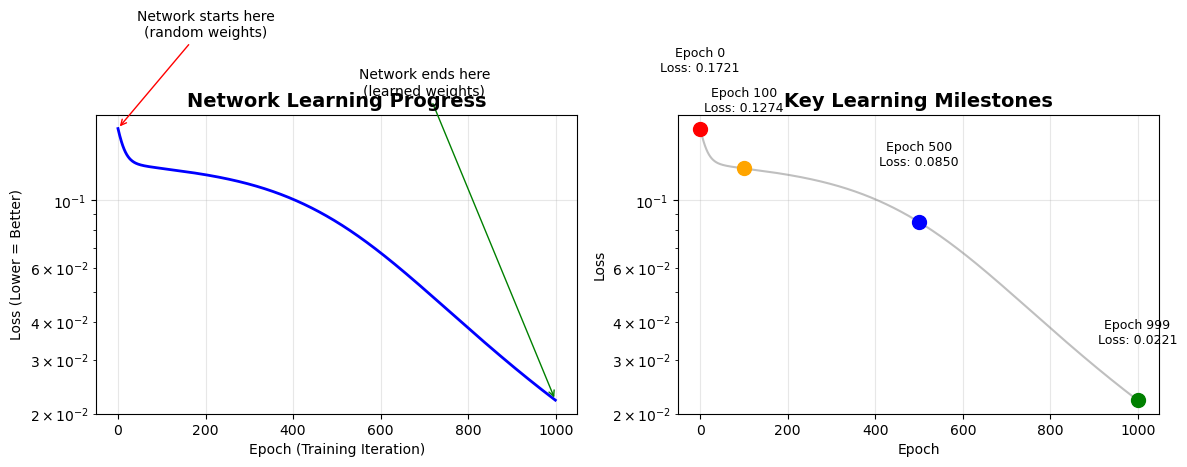

📈 Training started with loss: 0.172140
📉 Training ended with loss: 0.022139
🎯 Improvement: 87.1% reduction in error!


In [25]:
def plot_training_progress(losses):
    """Visualize how the network learned over time"""
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Loss over time
    plt.subplot(1, 2, 1)
    plt.plot(losses, 'b-', linewidth=2)
    plt.title('Network Learning Progress', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch (Training Iteration)')
    plt.ylabel('Loss (Lower = Better)')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale to see the improvement better
    
    # Add annotations
    plt.annotate('Network starts here\n(random weights)', 
                xy=(0, losses[0]), xytext=(200, losses[0]*2),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, ha='center')
    
    plt.annotate('Network ends here\n(learned weights)', 
                xy=(len(losses)-1, losses[-1]), xytext=(len(losses)-300, losses[-1]*10),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=10, ha='center')
    
    # Plot 2: Before vs After comparison
    plt.subplot(1, 2, 2)
    
    epochs_to_show = [0, 100, 500, 999]
    colors = ['red', 'orange', 'blue', 'green']
    
    for i, (epoch, color) in enumerate(zip(epochs_to_show, colors)):
        plt.scatter(epoch, losses[epoch], color=color, s=100, zorder=5)
        plt.text(epoch, losses[epoch]*1.5, f'Epoch {epoch}\nLoss: {losses[epoch]:.4f}', 
                ha='center', va='bottom', fontsize=9)
    
    plt.plot(losses, 'gray', alpha=0.5)
    plt.title('Key Learning Milestones', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Training started with loss: {losses[0]:.6f}")
    print(f"📉 Training ended with loss: {losses[-1]:.6f}")
    print(f"🎯 Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}% reduction in error!")

plot_training_progress(training_losses)

## Step 8: Understanding What Happened

Let's compare the weights before and after training to see what changed!

In [26]:
def show_weight_changes():
    """Show how the weights changed during training"""
    print("🔍 WEIGHT ANALYSIS - What Did the Network Learn?")
    print("=" * 60)
    
    # Create a new network with the original random weights for comparison
    np.random.seed(42)  # Same seed as before
    original_weights_ih = np.random.uniform(-1, 1, (2, 2))
    original_weights_ho = np.random.uniform(-1, 1, (2, 1))
    
    print("📊 BEFORE TRAINING (Random Weights):")
    print(f"Input→Hidden weights:\n{original_weights_ih}")
    print(f"Hidden→Output weights:\n{original_weights_ho}")
    
    print("\n📊 AFTER TRAINING (Learned Weights):")
    print(f"Input→Hidden weights:\n{network.weights_input_to_hidden}")
    print(f"Hidden→Output weights:\n{network.weights_hidden_to_output}")
    
    print("\n🔄 CHANGES:")
    ih_change = network.weights_input_to_hidden - original_weights_ih
    ho_change = network.weights_hidden_to_output - original_weights_ho
    
    print(f"Input→Hidden change:\n{ih_change}")
    print(f"Hidden→Output change:\n{ho_change}")
    
    print("\n💡 The network automatically figured out what weights work best!")
    print("   This is the power of machine learning - it learns patterns from data.")

show_weight_changes()

🔍 WEIGHT ANALYSIS - What Did the Network Learn?
📊 BEFORE TRAINING (Random Weights):
Input→Hidden weights:
[[-0.25091976  0.90142861]
 [ 0.46398788  0.19731697]]
Hidden→Output weights:
[[-0.68796272]
 [-0.68801096]]

📊 AFTER TRAINING (Learned Weights):
Input→Hidden weights:
[[-1.63163349  1.33641428]
 [-1.53369046  0.92659473]]
Hidden→Output weights:
[[-3.01859377]
 [ 1.72158577]]

🔄 CHANGES:
Input→Hidden change:
[[-1.38071372  0.43498567]
 [-1.99767834  0.72927776]]
Hidden→Output change:
[[-2.33063105]
 [ 2.40959673]]

💡 The network automatically figured out what weights work best!
   This is the power of machine learning - it learns patterns from data.


## Summary: What You've Learned About Training

### 🎯 **Key Training Concepts:**

1. **Training = Adjusting Weights**: The network learns by changing its weights

2. **Loss Function**: Measures how wrong the network is (lower = better)

3. **Forward Pass**: Calculate the network's prediction

4. **Backpropagation**: Calculate how to improve the weights

5. **Learning Rate**: How big steps to take when adjusting weights

6. **Epochs**: Number of times to go through the training data

### 🔄 **The Training Process:**
```
1. Start with random weights
2. Make a prediction (forward pass)
3. Calculate error (loss function)
4. Adjust weights to reduce error (backpropagation)
5. Repeat until the network is good enough
```

### 🧠 **Why This Works:**
- The network automatically finds patterns in the data
- Each training iteration makes it slightly better
- Eventually, it learns to make good predictions

**Next Steps**: Now you understand both how neural networks work AND how they learn! You're ready to tackle more complex problems and datasets.